In [1]:
plt.style.use('bmh')

In [2]:
NORM = True # if we need to normalize data
IND_TRAIN = 7 # index of the data we need to predict
HOLDOUT = 2 # number of hours to skip before first prediction

### Create neural network structure

In [3]:
from keras import layers
from keras import models
from keras import Input

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1152      
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 12)                204       
Total params: 1,628
Trainable params: 1,628
Non-trainable params: 0
_________________________________________________________________


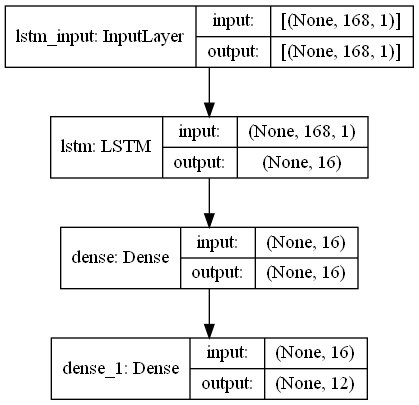

In [4]:
# 1) LSTM with Vector Output
# here you have: 1 feature, 24*7 periods - input length, 12 periods - output
modelname = 'lstm_16'
n_features    = 1
n_periods_in  = 24*7
n_periods_out = 12
model = models.Sequential()
model.add(layers.LSTM(16, input_shape=(n_periods_in, n_features)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(n_periods_out))
model.summary()

# # 2) LSTM Encoder-Decoder with Vector Output
# # encoder
# model = models.Sequential()
# model.add(layers.LSTM(32, activation='relu', input_shape=(n_periods_in, n_features)))
# # decoder
# model.add(layers.RepeatVector(n_periods_out))
# model.add(layers.LSTM(32, activation='relu', return_sequences=True))
# model.add(layers.TimeDistributed(layers.Dense(16, activation='relu')))
# model.add(layers.TimeDistributed(layers.Dense(1)))
# model.summary()

from tensorflow.keras import utils
_ = utils.plot_model(model, to_file=f'pictures/{modelname}.png', show_shapes=True)
_

### Read dataset and create data generators

In [5]:
######################################
# Keras preprocessing
######################################
# generators:
def ts_generator_rnn(data: np.ndarray, 
                     x_len: int = 5,
                     x_feats: list = None,
                     x_split = [],
                     delay = 0,
                     y_len: int = 2,
                     y_feats: int = 0,
                     batch_size: int = 128,
                    ) -> (np.ndarray, np.ndarray):
    """
    Функция для генерации последовательностей для обучения рекурентных нейронных сетей.

    Параметры:
    -----------
    data: np.ndarray
        Двумерный массив, у которого строки - временные значения, а столбцы - переменные.
    x_len: int, default=5
        Длина входной последовательности (например, по 5 предыдущим дням хотим спрогнозировать 2 следующих дня).
    x_feats: int, default=[0]
        Индексы входных фичей.
    x_split: list, default=[]
        Применимо для сетки ConvLSTM2D, которой на вход идёт [samples, timesteps, rows, cols, channels]
        Если задан непустой список [timesteps, rows, cols], тогда x_len будет проигнорировано.
        Если задали, например, значение [3,1,7], то это значит будет 21 период и отдельно 3 по 7 периодов прогоняются отдельно.
    delay: int, default=0
        Отступ - количество периодов, которое надо пропустить после входной последовательности.
    y_len: int, default=2
        Длина выходной последовательности (например, по 5 предыдущим дням хотим спрогнозировать 2 следующих дня).
    y_feats: int, default=0
        Индекс выходной фичи.
    batch_size: int, default=128
        Размер батча.

    Возвращаемое значение:
    ----------------------
    x: np.ndarray
        Массив входных значений формата:  (размер батча, размер входной последовательности, размер фичей).
        Или [samples, timesteps, rows, cols, channels].
    y: np.ndarray
        Массив выходных значений формата: (размер батча, размер входной последовательности, размер фичей).
    """
    if x_feats is None:
        x_feats = list(range(data.shape[1]))
    in_start = 0
    max_index = len(data)
    if len(x_split) != 0:
        x_len = 1
        for x1 in x_split:
            x_len = x1 * x_len
    if max_index < batch_size + x_len + y_len + delay:
        print('Choose lower batch_size!')
        return
    while 1:
        x, y = list(), list()
        for it in range(batch_size):
            # define the end of the input sequence
            in_end = in_start + x_len
            out_start = in_end + delay
            out_end = out_start + y_len
            # get data
            x.append(data[in_start:in_end, x_feats])
            y.append(data[out_start:out_end, y_feats])    
            # move along one time step or reset
            in_start += 1
            if out_end == max_index:
                in_start = 0
        x, y = np.array(x), np.array(y)
        if len(x_split) != 0:
            x = x.reshape([x.shape[0]] + x_split + [x.shape[-1]])
        yield x, y

(16784, 8)


,Open,High,Low,Close,Adj Close,Volume,Close_pred,Close_diff
2020-12-31 21:00:00,743.33,745.13,738.04,738.61,738.61,0,931.13,-192.52
2020-12-31 22:00:00,738.61,742.59,737.39,742.36,742.36,0,932.24,-189.87
2020-12-31 23:00:00,742.25,742.25,735.61,737.96,737.96,0,932.69,-194.72


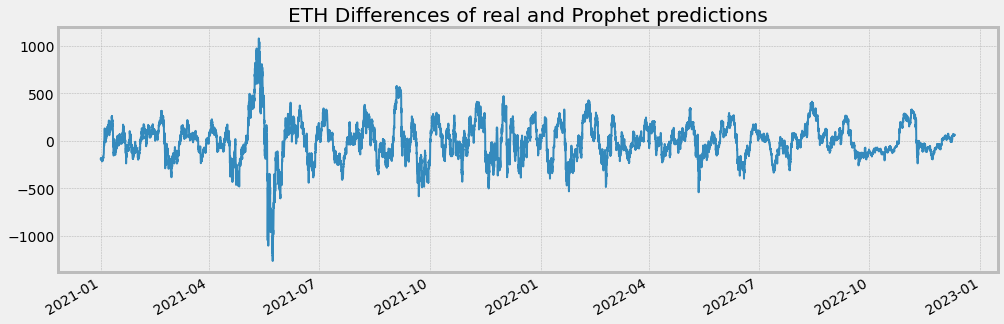

In [21]:
data = pd.read_pickle('../data/ETH_USD.pkl')
data.index = pd.to_datetime(data.index.map(lambda x: str(x).split('+')[0]))
print(data.shape)
display(data[:3])

_ = data.Close_diff.plot(figsize = (15,5), title = 'ETH Differences of real and Prophet predictions')
plt.show()

In [7]:
# Normalization
data = data.values
if NORM:
    data_mean = data.mean(axis = 0)
    data_std  = data.std(axis = 0)
    data = (data - data_mean) / data_std

data_mean = data_mean[IND_TRAIN]
data_std = data_std[IND_TRAIN]
print('mean:', data_mean)
print('std:', data_std)

mean: 0.018249453067362205
std: 197.8245613756893


In [8]:
# generators
index_train = 24*30 # last values we used to validate

gen_train = ts_generator_rnn(data, 
                             x_len = n_periods_in,
                             x_feats = [IND_TRAIN],
                             y_len = n_periods_out,
                             y_feats = IND_TRAIN,
                             delay = HOLDOUT,
                             batch_size = 512)
gen_valid = ts_generator_rnn(data[-index_train:], 
                             x_len = n_periods_in,
                             x_feats = [IND_TRAIN],
                             y_len = n_periods_out,
                             y_feats = IND_TRAIN,
                             delay = HOLDOUT,
                             batch_size = 24*20)

In [9]:
x,y = next(gen_train)
print(x.shape, y.shape)

(512, 168, 1) (512, 12)


### Training model

In [10]:
from keras import optimizers
from keras import losses
from keras import metrics
from keras import callbacks

In [11]:
# 4) compile model
model.compile(
    optimizer = optimizers.rmsprop_v2.RMSprop(lr=0.001),
    loss      = losses.mse,
    metrics   = ['mae']
)

In [12]:
# 5) train model
history = model.fit_generator(
    gen_train,
    steps_per_epoch  = 50,
    epochs           = 30,
    validation_data  = gen_valid,
    validation_steps = 1
)

Epoch 1/30
50/50 [==============================] - 7s 113ms/step - loss: 1.0617 - mae: 0.7453 - val_loss: 0.0830 - val_mae: 0.2171
Epoch 2/30
50/50 [==============================] - 5s 102ms/step - loss: 0.5790 - mae: 0.5184 - val_loss: 0.0476 - val_mae: 0.1660
Epoch 3/30
50/50 [==============================] - 5s 103ms/step - loss: 0.6753 - mae: 0.5337 - val_loss: 0.0265 - val_mae: 0.1218
Epoch 4/30
50/50 [==============================] - 5s 108ms/step - loss: 0.4606 - mae: 0.4035 - val_loss: 0.0200 - val_mae: 0.1089
Epoch 5/30
50/50 [==============================] - 5s 104ms/step - loss: 0.3323 - mae: 0.3722 - val_loss: 0.0144 - val_mae: 0.0925
Epoch 6/30
50/50 [==============================] - 5s 104ms/step - loss: 0.3249 - mae: 0.3296 - val_loss: 0.0166 - val_mae: 0.1025
Epoch 7/30
50/50 [==============================] - 5s 104ms/step - loss: 0.2391 - mae: 0.3118 - val_loss: 0.0148 - val_mae: 0.0947
Epoch 8/30
50/50 [==============================] - 5s 101ms/step - loss: 0.

,loss,mae,val_loss,val_mae
0,1.06,0.75,0.08,0.22
1,0.58,0.52,0.05,0.17
2,0.68,0.53,0.03,0.12


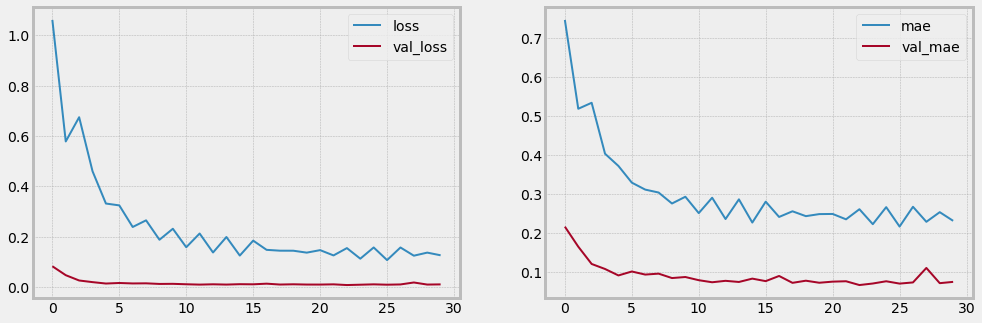

In [13]:
df_out = pd.DataFrame(history.history)
display(df_out[:3])
_,ax = plt.subplots(1,2,figsize = (15,5))
p = df_out.iloc[:,[0,2]].plot(ax = ax[0])
p = df_out.iloc[:,[1,3]].plot(ax = ax[1])

In [14]:
model.save(f'models/{modelname}.h5')

### Evaluation

In [15]:
x,y = next(gen_valid)
pred = model.predict(x)
print(pred.shape, x.shape, y.shape)
print(model.evaluate(x,y))

(480, 12) (480, 168, 1) (480, 12)
15/15 [==============================] - 0s 11ms/step - loss: 0.0111 - mae: 0.0761
[0.011092746630311012, 0.0761166661977768]


In [17]:
if NORM:
    pred = pred*data_std + data_mean
    y = y*data_std + data_mean
dif1 = y - pred
dif2 = dif1 / y

(480, 2)


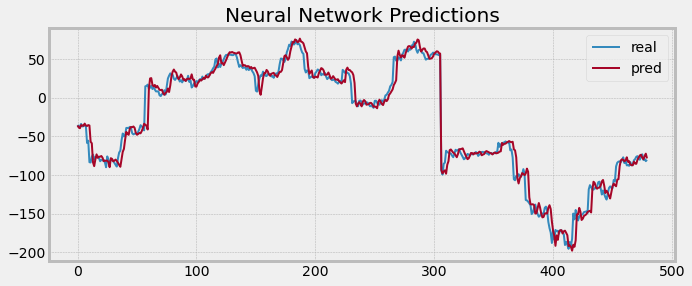

In [22]:
n1,n2 = y.shape
df_out = pd.DataFrame({
    'real': [y1[0] for y1 in y],
    'pred': [p1[0] for p1 in pred],
})
print(df_out.shape)
_ = df_out.plot(figsize = (10,4), title = 'Neural Network Predictions')

In [19]:
# MAE if we will use only prophet model
df_out.real.abs().mean()

63.36223128805093

In [20]:
# MAE if we will use prophet model + neural network
df_out['diff1'] = df_out.real - df_out.pred
df_out.diff1.abs().mean()

7.612656340615135